RAG tutorial

In [11]:
# %pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
# %pip install python-dotenv
# %pip install -qU langchain-ollama
# %pip install -qU langchain-core
# %pip install beautifulsoup4
# %pip install langchainhub
# %pip install langchain-community
# %pip install langchain-text-splitters
# %pip install langgraph
# %pip install typing-extensions
# %pip install -U langchain-chroma
# %pip install chromadb langchain langchain-community



  Using cached langchain_chroma-0.2.3-py3-none-any.whl.metadata (1.1 kB)
  Using cached chromadb-0.6.3-py3-none-any.whl.metadata (6.8 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached chroma_hnswlib-0.7.6.tar.gz (32 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached onnxruntime-1.21.1-cp313-cp313-win_amd64.whl.metadata (4.9 kB)
  Using cached opentelemetry_instrumentation_fastapi-0.53b1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached bcrypt-4.3.0-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using cached typer-0.15.3-py3-none-any.whl.

  error: subprocess-exited-with-error
  
  × Building wheel for chroma-hnswlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [5 lines of output]
      running bdist_wheel
      running build
      running build_ext
      building 'hnswlib' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for chroma-hnswlib

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Failed to build installable wheels for some pyproject.toml based projects (chroma-hnswlib)


  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached fastapi-0.115.9-py3-none-any.whl.metadata (27 kB)
  Using cached onnxruntime-1.21.1-cp313-cp313-win_amd64.whl.metadata (4.9 kB)
  Using cached opentelemetry_instrumentation_fastapi-0.53b1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached bcrypt-4.3.0-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using cached typer-0.15.3-py3-none-any.whl.metadata (15 kB)
  Using cached kubernetes-32.0.1-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached mmh3-5.1.0-cp313-cp313-win_amd64.whl.metadata (16 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached pyproject_hooks-1.2.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
  Using cached durati


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


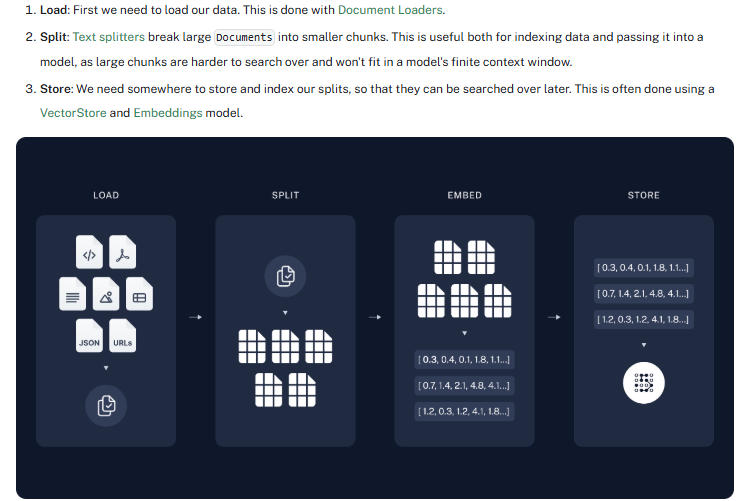

In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

Chat Model

In [2]:
import getpass
import os

if not os.environ.get("ANTHROPIC_API_KEY"):
  os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter API key for Anthropic: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("claude-3-5-sonnet-latest", model_provider="anthropic")

Embedding Model

In [3]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3")

Vector Store

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

App LLM Powered

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [6]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [ ]:
# This code adds the documents in the list `all_splits` to the vector store and returns a list of document IDs.
# `add_documents` is a method of the `InMemoryVectorStore` class which takes a list of documents as input.
# The method returns a list of document IDs which can be used to query the vector store.

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

Use langchain-chroma

In [11]:
from langchain_community.vectorstores import Chroma
# from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)


LangChain

In [12]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [ ]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

In [ ]:
async for step in graph.astream({"question": "What is Task Decomposition?"}, stream_mode="updates"):
    print(step)

Customizing Prompt

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [ ]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [ ]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [ ]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()